# Picture Memorability:  with Caffe

In this example we'll estimate human visual memorability of pictures with a pretrained CaffeNet model.(@inproceedings{ICCV15_Khosla,
 author = "Aditya Khosla and Akhil S. Raju and Antonio Torralba and Aude Oliva",
 title = "Understanding and Predicting Image Memorability at a Large Scale",
 booktitle = "International Conference on Computer Vision (ICCV)",
 year = "2015"
}


We'll compare CPU and GPU modes and then dig into the model to inspect features and the output.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

../python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
../python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
../python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [3]:
import os
if os.path.isfile(caffe_root + 'models/memnet/memnet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/memnet/deploy.prototxt'
model_weights = caffe_root + 'models/memnet/memnet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### 3. CPU classification

* Now we're ready to perform pic scoring. Even though we'll only score one image, we'll set a batch size of 50 to demonstrate batching.

In [6]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

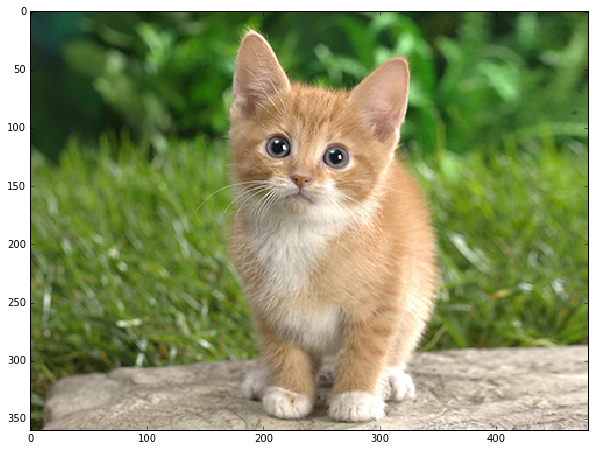

In [7]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [27]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image
### perform classification
output = net.forward()
print 'predicted memorability', output.values()[0][0].tolist()[0]

predicted memorability 0.821355462074


* The net gives us a vector of probabilities; The memorability of this picture is 0.821355462074